In [1]:
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

In [2]:
import os

#os.environ["CUDA_VISIBLE_DEVICES"]="-1" 
import tensorflow as tf
import numpy as np

# Set the seed for random operations. 
# This let our experiments to be reproducible. 
SEED = 1234
tf.random.set_seed(SEED)  

# Get current working directory
cwd = os.getcwd()

# Set GPU memory growth
# Allows to only as much GPU memory as needed
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    try:
        # Currently, memory growth needs to be the same across GPUs
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
        logical_gpus = tf.config.experimental.list_logical_devices('GPU')
        print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
    except RuntimeError as e:
        # Memory growth must be set before GPUs have been initialized
        print(e)

1 Physical GPUs, 1 Logical GPUs


Dataset
---

In [3]:
# ImageDataGenerator
# ------------------
import shutil
from tensorflow.keras.preprocessing.image import ImageDataGenerator

#directories used to handle the datasets
dataset_dir = os.path.join(cwd, '../input/ann-and-dl-image-segmentation/Segmentation_Dataset')
training_dir = os.path.join(dataset_dir, 'training')
#validation_dir = os.path.join(dataset_dir, 'validation')
images_dir = os.path.join(training_dir, 'images', 'img')
masks_dir = os.path.join(training_dir, 'masks', 'img')

In [4]:
# ImageDataGenerator
# ------------------

from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.vgg16 import preprocess_input

apply_data_augmentation = True

# Create training ImageDataGenerator object
# We need two different generators for images and corresponding masks
if apply_data_augmentation:
    train_img_data_gen = ImageDataGenerator(validation_split=0.1,
                                            rotation_range=10,
                                            width_shift_range=10,
                                            height_shift_range=10,
                                            zoom_range=0.3,
                                            horizontal_flip=True,
                                            vertical_flip=True,
                                            fill_mode='nearest',
                                            rescale=1./255,
                                            preprocessing_function=preprocess_input)
    train_mask_data_gen = ImageDataGenerator(validation_split=0.1,
                                             rotation_range=10,
                                             width_shift_range=10,
                                             height_shift_range=10,
                                             zoom_range=0.3,
                                             horizontal_flip=True,
                                             vertical_flip=True,
                                             fill_mode='nearest',
                                             preprocessing_function=preprocess_input)
else:
    train_img_data_gen = ImageDataGenerator(validation_split=0.1,
                                            rescale=1./255,
                                            preprocessing_function=preprocess_input)
    train_mask_data_gen = ImageDataGenerator(validation_split=0.1,
                                            preprocessing_function=preprocess_input)

# Create validation and test ImageDataGenerator objects
valid_img_data_gen = ImageDataGenerator(rescale=1./255, preprocessing_function=preprocess_input)
valid_mask_data_gen = ImageDataGenerator(preprocessing_function=preprocess_input)

In [5]:
# Create generators to read images from dataset directory
# -------------------------------------------------------

# Batch size
bs = 8

# img shape
img_h = 256
img_w = 256

In [6]:
# Training
# Two different generators for images and masks
# ATTENTION: here the seed is important!! We have to give the same SEED to both the generator
# to apply the same transformations/shuffling to images and corresponding masks
train_img_gen = train_img_data_gen.flow_from_directory(os.path.join(training_dir, 'images'),
                                                       target_size=(img_h, img_w),
                                                       batch_size=bs, 
                                                       class_mode=None, # Because we have no class subfolders in this case
                                                       shuffle=True,
                                                       interpolation='bilinear',
                                                       subset='training',
                                                       seed=SEED)  
train_mask_gen = train_mask_data_gen.flow_from_directory(os.path.join(training_dir, 'masks'),
                                                         target_size=(img_h, img_w),
                                                         batch_size=bs,
                                                         class_mode=None, # Because we have no class subfolders in this case
                                                         shuffle=True,
                                                         interpolation='bilinear',
                                                         subset='training',
                                                         seed=SEED)
train_gen = zip(train_img_gen, train_mask_gen)

# Validation
valid_img_gen = train_img_data_gen.flow_from_directory(os.path.join(training_dir, 'images'),
                                                       target_size=(img_h, img_w),
                                                       batch_size=bs, 
                                                       class_mode=None, # Because we have no class subfolders in this case
                                                       shuffle=False,
                                                       interpolation='bilinear',
                                                       subset='validation',
                                                       seed=SEED)
valid_mask_gen = train_mask_data_gen.flow_from_directory(os.path.join(training_dir, 'masks'),
                                                         target_size=(img_h, img_w),
                                                         batch_size=bs, 
                                                         class_mode=None, # Because we have no class subfolders in this case
                                                         shuffle=False,
                                                         interpolation='bilinear',
                                                         subset='validation',
                                                         seed=SEED)
valid_gen = zip(valid_img_gen, valid_mask_gen)

Found 6883 images belonging to 1 classes.
Found 6883 images belonging to 1 classes.
Found 764 images belonging to 1 classes.
Found 764 images belonging to 1 classes.


In [7]:
# Create Dataset objects
# ----------------------

# Training
# --------
train_dataset = tf.data.Dataset.from_generator(lambda: train_gen,
                                               output_types=(tf.float32, tf.float32),
                                               output_shapes=([None, img_h, img_w, 3], [None, img_h, img_w, 3]))

def prepare_target(x_, y_):
    y_ = tf.cast(tf.expand_dims(y_[..., 0], -1), dtype=tf.float32)
    return x_, tf.where(y_ > 0, tf.ones_like(y_, dtype=tf.float32), tf.zeros_like(y_, dtype=tf.float32))

train_dataset = train_dataset.map(prepare_target)
    
# Repeat
train_dataset = train_dataset.repeat()

# Validation
# ----------
valid_dataset = tf.data.Dataset.from_generator(lambda: valid_gen, 
                                               output_types=(tf.float32, tf.float32),
                                               output_shapes=([None, img_h, img_w, 3], [None, img_h, img_w, 3]))
valid_dataset = valid_dataset.map(prepare_target)

# Repeat
valid_dataset = valid_dataset.repeat()

<IPython.core.display.Javascript object>


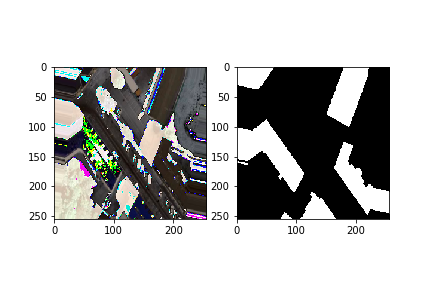

<tf.Tensor: shape=(4,), dtype=int32, numpy=array([  8, 256, 256,   3], dtype=int32)>

<tf.Tensor: shape=(4,), dtype=int32, numpy=array([  8, 256, 256,   1], dtype=int32)>

<tf.Tensor: shape=(4,), dtype=int32, numpy=array([  8, 256, 256,   3], dtype=int32)>

<tf.Tensor: shape=(4,), dtype=int32, numpy=array([  8, 256, 256,   1], dtype=int32)>

<tf.Tensor: shape=(4,), dtype=int32, numpy=array([  8, 256, 256,   3], dtype=int32)>

<tf.Tensor: shape=(4,), dtype=int32, numpy=array([  8, 256, 256,   1], dtype=int32)>

<tf.Tensor: shape=(4,), dtype=int32, numpy=array([  8, 256, 256,   3], dtype=int32)>

<tf.Tensor: shape=(4,), dtype=int32, numpy=array([  8, 256, 256,   1], dtype=int32)>

<tf.Tensor: shape=(4,), dtype=int32, numpy=array([  8, 256, 256,   3], dtype=int32)>

<tf.Tensor: shape=(4,), dtype=int32, numpy=array([  8, 256, 256,   1], dtype=int32)>

<tf.Tensor: shape=(4,), dtype=int32, numpy=array([  8, 256, 256,   3], dtype=int32)>

<tf.Tensor: shape=(4,), dtype=int32, numpy=array([  8, 256, 256,   1], dtype=int32)>

<tf.Tensor: shape=(4,), dtype=int32, numpy=array([  8, 256, 256,   3], dtype=int32)>

<tf.Tensor: shape=(4,), dtype=int32, numpy=array([  8, 256, 256,   1], dtype=int32)>

<tf.Tensor: shape=(4,), dtype=int32, numpy=array([  8, 256, 256,   3], dtype=int32)>

<tf.Tensor: shape=(4,), dtype=int32, numpy=array([  8, 256, 256,   1], dtype=int32)>

<tf.Tensor: shape=(4,), dtype=int32, numpy=array([  8, 256, 256,   3], dtype=int32)>

<tf.Tensor: shape=(4,), dtype=int32, numpy=array([  8, 256, 256,   1], dtype=int32)>

<tf.Tensor: shape=(4,), dtype=int32, numpy=array([  8, 256, 256,   3], dtype=int32)>

<tf.Tensor: shape=(4,), dtype=int32, numpy=array([  8, 256, 256,   1], dtype=int32)>

In [8]:
# Let's test data generator
# -------------------------
import time
import matplotlib.pyplot as plt

%matplotlib notebook

fig, ax = plt.subplots(1, 2)
fig.show()

# Assign a color to each class
colors_dict = {}
colors_dict[1] = [255, 255, 255]  # foreground
colors_dict[0] = [0, 0, 0]  # background

iterator = iter(train_dataset)

for _ in range(10):
    augmented_img, target = next(iterator)
    tf.shape(augmented_img)
    augmented_img = augmented_img[0]   # First element
    augmented_img = augmented_img * 255  # denormalize
    
    
    tf.shape(target)
    
    target = np.array(target[0, ..., 0])   # First element (squeezing channel dimension)
    
    # Assign colors (just for visualization)
    target_img = np.zeros([target.shape[0], target.shape[1], 3])
    
    target_img[np.where(target == 0)] = colors_dict[0]
    target_img[np.where(target == 1)] = colors_dict[1]
    
    ax[0].imshow(np.uint8(augmented_img))
    ax[1].imshow(np.uint8(target_img))
    
    fig.canvas.draw()
    #time.sleep(10)

In [9]:
np.unique(target_img)
np.unique(target)

array([  0., 255.])

array([0., 1.], dtype=float32)

In [10]:
transfer_model = tf.keras.applications.VGG16(weights='imagenet', include_top=False, input_shape=(img_h, img_w, 3))
transfer_model.summary()
for layer in transfer_model.layers[:11]:    
    layer.trainable = False
for layer in transfer_model.layers[11:]:    
    layer.trainable = True    


def create_model(depth, start_f, num_classes, dynamic_input_shape):
    
    input_shape = [8, 8, 512]
    
    start_f = 512
    inputs = tf.keras.Input(shape=input_shape)
    
    conv9 = tf.keras.layers.Conv2D(filters=start_f,
                                kernel_size=(3, 3),
                                activation='relu',
                                strides=(1, 1),
                                padding='same',
                                input_shape=[None])(inputs)
    conv10 = tf.keras.layers.Conv2D(filters=start_f,
                                kernel_size=(3, 3),
                                activation='relu',
                                strides=(1, 1),
                                padding='same',
                                input_shape=[None])(conv9)
    drop5 = tf.keras.layers.Dropout(0.1, seed=SEED)(conv10)
    
    #Decoder
    start_f = start_f // 2
    up1 = tf.keras.layers.UpSampling2D(2, interpolation='bilinear')(drop5)
    #transf1 = tf.keras.Input(shape=[16,16,512])
    #transf1 = transfer_model.get_layer(name='block5_conv3')(transfer_model.get_layer(name='block5_conv2'))
    #conc1 = tf.keras.layers.Concatenate()(transf1,up1)
    conv11 = tf.keras.layers.Conv2D(filters=start_f,
                                 kernel_size=(3, 3),
                                 activation='relu',
                                 strides=(1, 1),
                                 padding='same')(up1)
    conv12 = tf.keras.layers.Conv2D(filters=start_f,
                                 kernel_size=(3, 3),
                                 activation='relu',
                                 strides=(1, 1),
                                 padding='same')(conv11)
    
    start_f = start_f // 2
    up2 = tf.keras.layers.UpSampling2D(2, interpolation='bilinear')(conv12)
    #conc2 = tf.keras.layers.concatenate([conv6,up2], axis=3)
    conv13 = tf.keras.layers.Conv2D(filters=start_f,
                                 kernel_size=(3, 3),
                                 activation='relu',
                                 strides=(1, 1),
                                 padding='same')(up2)
    conv14 = tf.keras.layers.Conv2D(filters=start_f,
                                 kernel_size=(3, 3),
                                 activation='relu',
                                 strides=(1, 1),
                                 padding='same')(conv13)
    #drop4 = tf.keras.layers.Dropout(0.2, seed=SEED)(conv14)
    start_f = start_f // 2
    up3 = tf.keras.layers.UpSampling2D(2, interpolation='bilinear')(conv14)
    #conc3 = tf.keras.layers.concatenate([conv4,up3], axis=3)
    conv15 = tf.keras.layers.Conv2D(filters=start_f,
                                 kernel_size=(3, 3),
                                 activation='relu',
                                 strides=(1, 1),
                                 padding='same')(up3)
    conv16 = tf.keras.layers.Conv2D(filters=start_f,
                                 kernel_size=(3, 3),
                                 activation='relu',
                                 strides=(1, 1),
                                 padding='same')(conv15)
    start_f = start_f // 2
    up4 = tf.keras.layers.UpSampling2D(2, interpolation='bilinear')(conv16)
    #conc4 = tf.keras.layers.concatenate([conv2,up4], axis=3)
    conv17 = tf.keras.layers.Conv2D(filters=start_f,
                                 kernel_size=(3, 3),
                                 activation='relu',
                                 strides=(1, 1),
                                 padding='same')(up4)
    conv18 = tf.keras.layers.Conv2D(filters=start_f,
                                 kernel_size=(3, 3),
                                 activation='relu',
                                 strides=(1, 1),
                                 padding='same')(conv17)
    
    start_f = start_f // 2
    up5 = tf.keras.layers.UpSampling2D(2, interpolation='bilinear')(conv18)
    #conc4 = tf.keras.layers.concatenate([conv2,up4], axis=3)
    conv19 = tf.keras.layers.Conv2D(filters=start_f,
                                 kernel_size=(3, 3),
                                 activation='relu',
                                 strides=(1, 1),
                                 padding='same')(up5)
    conv20 = tf.keras.layers.Conv2D(filters=start_f,
                                 kernel_size=(3, 3),
                                 activation='relu',
                                 strides=(1, 1),
                                 padding='same')(conv19)
    
    #Output
    outputs = tf.keras.layers.Conv2D(filters=num_classes,
                                 kernel_size=(1, 1),
                                 strides=(1, 1),
                                 padding='same',
                                 activation='sigmoid')(conv20)
    
    decoder = tf.keras.models.Model(inputs=[inputs], outputs=[outputs])
    decoder.summary()
    model = tf.keras.Sequential()
    model.add(transfer_model)
    model.add(decoder)
    
    return model

58892288/58889256 [==============================] - 2s 0us/step
Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 256, 256, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 256, 256, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 256, 256, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 128, 128, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 128, 128, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 128, 128, 128)     147584    
______________________________________________________________

In [11]:
model = create_model(depth=4, 
                     start_f=4, 
                     num_classes=1, 
                     dynamic_input_shape=False)

# Visualize created model as a table
model.summary()

# Visualize initialized weights
model.weights

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 8, 8, 512)]       0         
_________________________________________________________________
conv2d (Conv2D)              (None, 8, 8, 512)         2359808   
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 8, 8, 512)         2359808   
_________________________________________________________________
dropout (Dropout)            (None, 8, 8, 512)         0         
_________________________________________________________________
up_sampling2d (UpSampling2D) (None, 16, 16, 512)       0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 16, 16, 256)       1179904   
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 16, 16, 256)       590080

[<tf.Variable 'block1_conv1/kernel:0' shape=(3, 3, 3, 64) dtype=float32, numpy=
 array([[[[ 4.29470569e-01,  1.17273867e-01,  3.40129584e-02, ...,
           -1.32241577e-01, -5.33475243e-02,  7.57738389e-03],
          [ 5.50379455e-01,  2.08774377e-02,  9.88311544e-02, ...,
           -8.48205537e-02, -5.11389151e-02,  3.74943428e-02],
          [ 4.80015397e-01, -1.72696680e-01,  3.75577137e-02, ...,
           -1.27135560e-01, -5.02991639e-02,  3.48965675e-02]],
 
         [[ 3.73466998e-01,  1.62062630e-01,  1.70863140e-03, ...,
           -1.48207128e-01, -2.35300660e-01, -6.30356818e-02],
          [ 4.40074533e-01,  4.73412387e-02,  5.13819456e-02, ...,
           -9.88498852e-02, -2.96195745e-01, -7.04357103e-02],
          [ 4.08547401e-01, -1.70375049e-01, -4.96297423e-03, ...,
           -1.22360572e-01, -2.76450396e-01, -3.90796512e-02]],
 
         [[-6.13601133e-02,  1.35693997e-01, -1.15694344e-01, ...,
           -1.40158370e-01, -3.77666801e-01, -3.00509870e-01],
    

In [12]:
# Optimization params
# -------------------

# Loss

def dice_loss(y_true, y_pred):
    numerator = 2 * tf.reduce_sum(y_true * y_pred, axis=-1)
    denominator = tf.reduce_sum(y_true + y_pred, axis=-1)
    return 1 - (numerator + 1) / (denominator + 1)

def combined_loss(y_true, y_pred):
    def dice_loss1(y_true, y_pred):
        numerator = 2 * tf.reduce_sum(y_true * y_pred, axis=(1,2,3))
        denominator = tf.reduce_sum(y_true + y_pred, axis=(1,2,3))
        return tf.reshape(1 - numerator / denominator, (-1, 1, 1))

    return tf.keras.losses.binary_crossentropy(y_true, y_pred) + dice_loss1(y_true, y_pred)

# Sparse Categorical Crossentropy to use integers (mask) instead of one-hot encoded labels
loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False)
# learning rate
lr = 1e-3
sgd = tf.keras.optimizers.SGD(lr=lr, decay=1e-5, momentum=0.5, nesterov=True)
sparse = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False) 
# -------------------

# Validation metrics
# ------------------
def my_IoU(y_true, y_pred):
    # from pobability to predicted class {0, 1}
    y_pred = tf.cast(y_pred > 0.5, tf.float32) # when using sigmoid. Use argmax for softmax

    # A and B
    intersection = tf.reduce_sum(y_true * y_pred)
    # A or B
    union = tf.reduce_sum(y_true) + tf.reduce_sum(y_pred) - intersection
    # IoU
    return intersection / union

# ------------------

# Compile Model
model.compile(optimizer=sgd, loss=[combined_loss], metrics=[my_IoU])

Training with callbacks
---

In [13]:
import os
from datetime import datetime

# from tensorflow.compat.v1 import ConfigProto
# from tensorflow.compat.v1 import InteractiveSession

# config = ConfigProto()
# config.gpu_options.allow_growth = True
# session = InteractiveSession(config=config)

cwd = os.getcwd()

exps_dir = os.path.join(cwd, 'segmentation_experiments')
if not os.path.exists(exps_dir):
    os.makedirs(exps_dir)

now = datetime.now().strftime('%b%d_%H-%M-%S')

model_name = 'UNet'

exp_dir = os.path.join(exps_dir, model_name + '_' + str(now))
if not os.path.exists(exp_dir):
    os.makedirs(exp_dir)
    
callbacks = []

# Model checkpoint
# ----------------
ckpt_dir = os.path.join(exp_dir, 'ckpts')
if not os.path.exists(ckpt_dir):
    os.makedirs(ckpt_dir)

ckpt_callback = tf.keras.callbacks.ModelCheckpoint(filepath=os.path.join(ckpt_dir, 'cp_{epoch:02d}.ckpt'), 
                                                   save_weights_only=True)  # False to save the model directly
callbacks.append(ckpt_callback)

# Visualize Learning on Tensorboard
# ---------------------------------
tb_dir = os.path.join(exp_dir, 'tb_logs')
if not os.path.exists(tb_dir):
    os.makedirs(tb_dir)
    
# By default shows losses and metrics for both training and validation
tb_callback = tf.keras.callbacks.TensorBoard(log_dir=tb_dir,
                                             profile_batch=0,
                                             histogram_freq=0)  # if 1 shows weights histograms
callbacks.append(tb_callback)

In [14]:
import matplotlib.pyplot as plt
%matplotlib notebook

# Early Stopping
# --------------
early_stop = True
if early_stop:
    es_callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=10)
    callbacks.append(es_callback)


history = model.fit(x=train_dataset,
          epochs=100,  #### set repeat in training dataset
          steps_per_epoch=len(train_img_gen),
          validation_data=valid_dataset,
          validation_steps=len(valid_img_gen), 
          callbacks=callbacks)

plt.figure(1)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Valid'], loc='upper left')
plt.savefig('loss.png')

plt.figure(2)
plt.plot(history.history['my_IoU'])
plt.plot(history.history['my_IoU'])
plt.title('Intersection over Union')
plt.ylabel('IoU')
plt.xlabel('Epoch')
plt.legend(['Train', 'Valid'], loc='upper left')
plt.savefig('my_IoU.png')
plt.show()

# How to visualize Tensorboard

# 1. tensorboard --logdir EXPERIMENTS_DIR --port PORT     <- from terminal
# 2. localhost:PORT   <- in your browser

Train for 861 steps, validate for 96 steps
Epoch 1/100
861/861 [==============================] - 275s 320ms/step - loss: 1.3087 - my_IoU: 0.0014 - val_loss: 1.2550 - val_my_IoU: 0.0977
Epoch 2/100
428/861 [=============>................] - ETA: 1:48 - loss: 1.2197 - my_IoU: 0.2608

KeyboardInterrupt: 

In [ ]:
import shutil
shutil.make_archive('training.zip', 'zip', 'segmentation_experiments')

Dataset Split Json creation
---

In [ ]:
import json

directories = os.listdir(training_dir)

dataset_split = {}

dataset_split["training"] =  os.listdir(images_dir)
                                                    
dataset_split["validation"] =  os.listdir(os.path.join(validation_dir, 'images', 'img'))
    
with open('dataset_split.json', 'w') as fp:
     json.dump(dataset_split, fp)

Compute Prediction
---

In [ ]:
import time
import matplotlib.pyplot as plt

from PIL import Image

%matplotlib notebook

# Cycle over test images
test_dir = os.path.join(dataset_dir, 'test')
test_img_dir = os.path.join(test_dir, 'images', 'img')

CSV File Creation
---

In [ ]:
import os
from datetime import datetime

def create_csv(results, results_dir='./'):

    csv_fname = 'results_'
    csv_fname += datetime.now().strftime('%b%d_%H-%M-%S') + '.csv'

    with open(csv_fname, 'w') as f:
        f.write('ImageId,EncodedPixels,Width,Height\n')

        for key, value in results.items():
            value
            f.write(key + ',' + str(value) + ',' + '256' + ',' + '256' + '\n')

Image Flatten Codification
----

In [ ]:
def rle_encode(img):
    # Flatten column-wise
    pixels = img.T.flatten()
    pixels
    pixels = np.concatenate([[0], pixels, [0]])
    pixels
    runs = np.where(pixels[1:] != pixels[:-1])[0] + 1
    runs
    runs[1::2] -= runs[::2]
    runs
    return ' '.join(str(x) for x in runs)

Model Predictions
---

In [ ]:
from PIL import Image
import numpy as np

img_filenames = next(os.walk(test_img_dir))[2]

model.load_weights(os.path.join(cwd, 'segmentation_experiments/UNet_Dec13_16-49-02/ckpts/cp_16.ckpt'))

fig, ax = plt.subplots(1, 2, figsize=(8, 8))
fig.show()

results={}
i=1
for img_filename in img_filenames:
    
    
    img = Image.open(os.path.join(test_img_dir, img_filename))
    img = img.resize((256, 256))
    
    img_arr = np.expand_dims(np.array(img), 0)
    img_arr = preprocess_input(img_arr)
    out_sigmoid = model.predict(x=img_arr / 255.)
    
    out_sigmoid = tf.cast(out_sigmoid > 0.5, tf.int32)
    out_sigmoid = out_sigmoid[0]
    print(out_sigmoid)
    # Get predicted class as the index corresponding to the maximum value in the vector probability
    # Assign colors (just for visualization)
    
    prediction_gray = np.zeros([256, 256, 1])
    #prediction_rgb = np.zeros([256, 256, 3])
    
    prediction_gray[np.where(out_sigmoid == 0)] = [0]
    prediction_gray[np.where(out_sigmoid == 1)] = [1]
    
    #prediction_rgb[np.where(out_sigmoid == 0)] = [0, 0, 0]
    #prediction_rgb[np.where(out_sigmoid == 1)] = [255, 255, 255]
    
    prediction_rgb = tf.where(out_sigmoid > 0, 
                             tf.constant(255, tf.int32, [256, 256, 3]),  #buildings
                             tf.constant(0, tf.int32, [256, 256, 3]))    #background
    
    #prediction_gray = tf.where(out_sigmoid > 0,
    #                           tf.constant(1, tf.int32, [256, 256, 1]),  #buildings
    #                           tf.constant(0, tf.int32, [256, 256, 1]))  #background

    
    runs = rle_encode(prediction_gray)
    results[img_filename[:-4]] = runs
    print(i)
    i+=1
    
    ax[0].imshow(np.uint8(img_arr[0, ...]))
    ax[1].imshow(np.uint8(prediction_rgb))
    
    fig.canvas.draw()
    #time.sleep(10)

create_csv(results)    